<a href="https://colab.research.google.com/github/veenqa/brain-tumar-classification/blob/main/brain_tumar_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Loading images from: /content/drive/MyDrive/archive (1)

Extracting deep features...

Performing clustering...


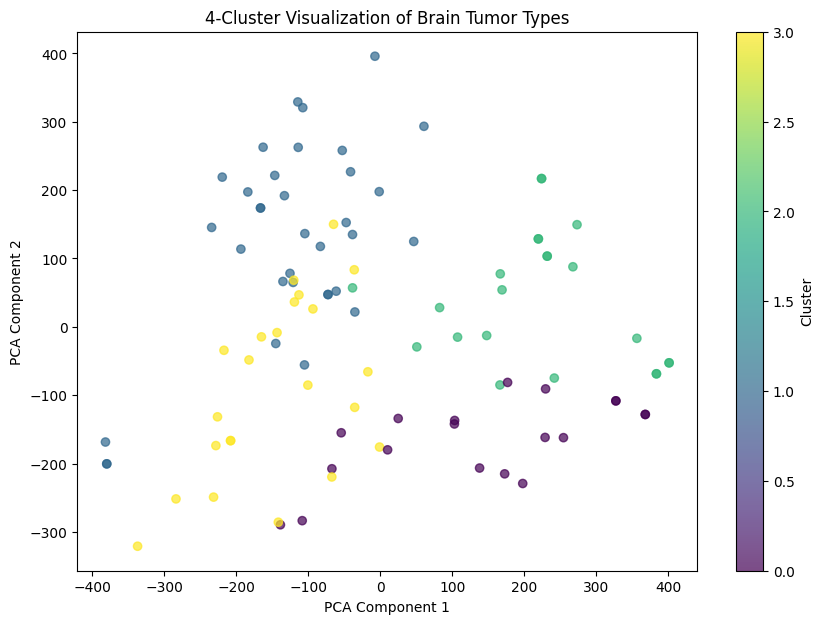


Cluster Distribution:
Cluster
1    34
3    23
2    22
0    19
Name: count, dtype: int64

Saved cluster assignments to 'tumor_clusters.csv'

Clustering Quality Metrics:
Silhouette Score: 0.0493

Displaying sample images from each cluster...


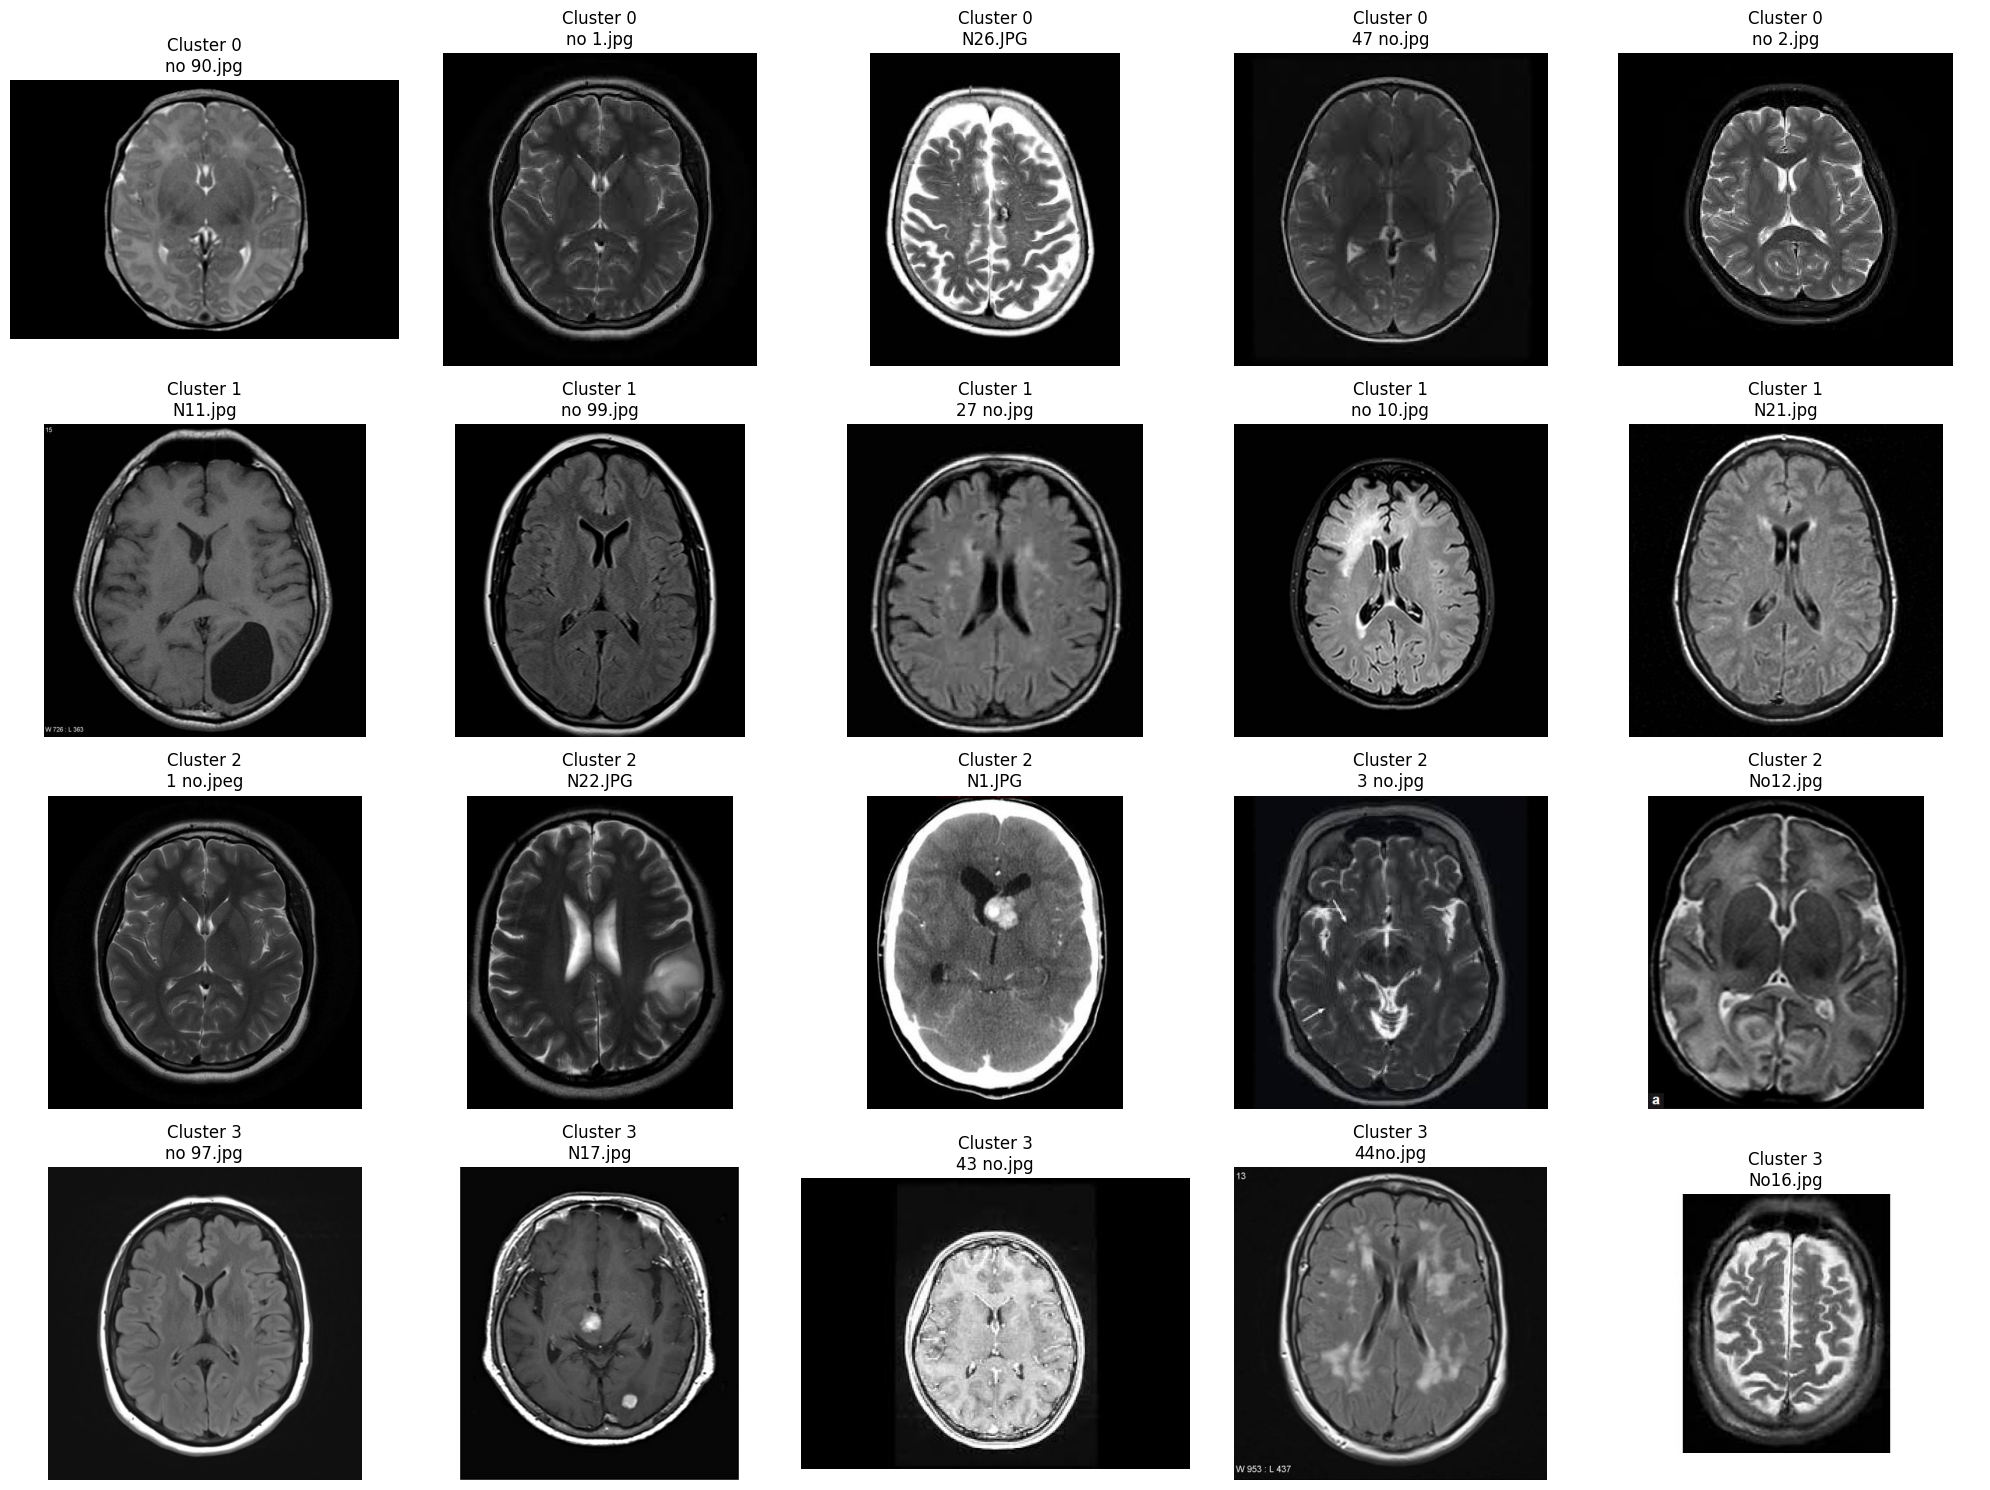

In [ ]:

!pip install numpy pandas matplotlib scikit-learn opencv-python tensorflow

import numpy as np
import cv2
import os
import tensorflow as tf
from google.colab import drive
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import pandas as pd
from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Model
from tensorflow.keras.preprocessing import image

drive.mount('/content/drive')


dataset_path = "/content/drive/MyDrive/archive (1)"

def load_images(folder_path, img_size=(224, 224)):
    images = []
    filenames = []
    print(f"Loading images from: {folder_path}")

    for filename in os.listdir(folder_path):
        img_path = os.path.join(folder_path, filename)
        if os.path.isfile(img_path):
            try:
                img = cv2.imread(img_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)  # Convert to RGB
                img = cv2.resize(img, img_size)
                images.append(img)
                filenames.append(filename)
            except Exception as e:
                print(f"Error loading {filename}: {str(e)}")

    return np.array(images), filenames


X, filenames = load_images(dataset_path)

base_model = ResNet50(weights='imagenet', include_top=False)
model = Model(inputs=base_model.input, outputs=base_model.layers[-2].output)

def extract_features(imgs):
    features = []
    for img in imgs:
        x = image.img_to_array(img)
        x = np.expand_dims(x, axis=0)
        x = tf.keras.applications.resnet50.preprocess_input(x)
        feat = model.predict(x, verbose=0)
        features.append(feat.flatten())
    return np.array(features)

print("\nExtracting deep features...")
features = extract_features(X)
print("\nPerforming clustering...")
kmeans = KMeans(n_clusters=4, random_state=42)
clusters = kmeans.fit_predict(features)
pca = PCA(n_components=2)
reduced_features = pca.fit_transform(features)

plt.figure(figsize=(10, 7))
plt.scatter(reduced_features[:, 0], reduced_features[:, 1],
            c=clusters, cmap='viridis', alpha=0.7)
plt.title('4-Cluster Visualization of Brain Tumor Types')
plt.xlabel('PCA Component 1')
plt.ylabel('PCA Component 2')
plt.colorbar(label='Cluster')
plt.show()

results = pd.DataFrame({
    'Filename': filenames,
    'Cluster': clusters,
    'PCA1': reduced_features[:, 0],
    'PCA2': reduced_features[:, 1]
})

print("\nCluster Distribution:")
print(results['Cluster'].value_counts())

# Save results
results.to_csv('tumor_clusters.csv', index=False)
print("\nSaved cluster assignments to 'tumor_clusters.csv'")
from sklearn.metrics import silhouette_score

print(f"\nClustering Quality Metrics:")
print(f"Silhouette Score: {silhouette_score(features, clusters):.4f}")
print("\nDisplaying sample images from each cluster...")
fig, axes = plt.subplots(4, 5, figsize=(20, 15))
for cluster in range(4):
    cluster_files = results[results['Cluster'] == cluster]['Filename'].sample(5, random_state=42)
    for idx, (ax, filename) in enumerate(zip(axes[cluster], cluster_files)):
        img_path = os.path.join(dataset_path, filename)
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        ax.imshow(img)
        ax.set_title(f"Cluster {cluster}\n{filename}")
        ax.axis('off')
plt.tight_layout()
plt.show()